Install required libraries.



In [30]:
import locale
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

path_data_file = "data/v1"

In [31]:
from typing import Optional, List  # Add this line
from langchain_core.callbacks import CallbackManager
from langchain.llms.base import LLM
from ollama import chat, ChatResponse
from pydantic import BaseModel  # Pydantic's BaseModel for field definitions

class OllamaLLM(LLM, BaseModel):
    model_name: str
    verbose: bool = False

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        if self.verbose:
            print(f"Sending prompt to {self.model_name}: {prompt}")
        response: ChatResponse = chat(
            model=self.model_name,
            messages=[{'role': 'user', 'content': prompt}]
        )
        return response.message.content

    @property
    def _llm_type(self) -> str:
        return "ollama"

# Replace LlamaCpp with OllamaLLM
model = OllamaLLM(model_name="llama3.2", verbose=True)

In [32]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
#
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

embd = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)


In [42]:
# save
import json
import os

# Save global_embeddings to a JSON file
def save_json(data, filename):
    os.makedirs(path_data_file, exist_ok=True)
    with open(path_data_file + filename, "w") as f:
        json.dump(data, f)

#load
def load_json(filename):
    with open(path_data_file + filename, "r") as f:
        return json.load(f)

In [43]:
import tiktoken
import matplotlib.pyplot as plt

## Helper Fuction to count the number of Tokensin each text
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [44]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://football360.ir/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()
docs = docs[:5]

# # LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
# url = "https://react.dev/community"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
# )
# docs_pydantic = loader.load()

# # LCEL w/ Self Query (outside the primary LCEL docs)
# url = "https://react.dev/learn"
# loader = RecursiveUrlLoader(
#     url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
# )
# docs_sq = loader.load()

# # Doc texts
# docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

In [45]:
# docs_texts = load_json("/docs_texts.json")
save_json(docs_texts,"/docs_texts.json")

In [46]:
len(docs_texts)

1

In [47]:
import json

# Convert docs to a JSON-serializable format
docs_data = [
    {
        "page_content": doc.page_content,
        "metadata": doc.metadata  # Assuming `metadata` is a dictionary or JSON-serializable
    }
    for doc in docs
]

# Save to a JSON file
with open(path_data_file + "/docs.json", "w", encoding="utf-8") as f:
    json.dump(docs_data, f, ensure_ascii=False, indent=4)

# ----------------------------------------------
# from langchain.schema import Document

# # Load from the JSON file
# with open(path_data_file + "/docs.json", "r", encoding="utf-8") as f:
#     docs_data = json.load(f)

# # Reconstruct the docs list (convert dictionaries back to Document objects)
# docs = [Document(page_content=doc["page_content"], metadata=doc["metadata"]) for doc in docs_data]

# # Example: Accessing content from loaded docs
# print(docs[0].page_content)


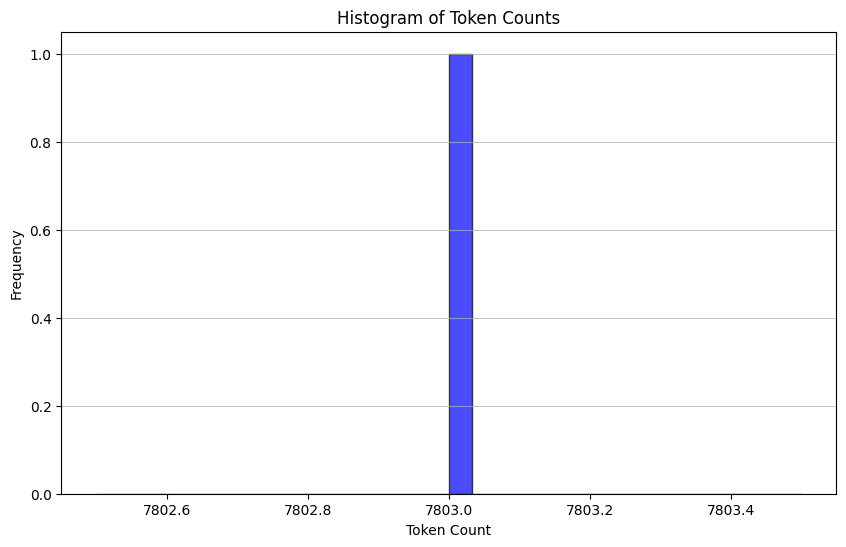

In [10]:
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()

In [11]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 7803


In [12]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 1000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)
#
print(f"Number of text splits generated: {len(texts_split)}")

Number of text splits generated: 12


In [13]:
save_json(texts_split, "/texts_split.json")

In [14]:
global_embeddings = [embd.embed_query(txt) for txt in texts_split]
print(len(global_embeddings[0]))

384


In [15]:
save_json(global_embeddings, "/global_embeddings.json")

c:\Users\Iranian\Desktop\New folder (2)\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[8.431068 7.113435]


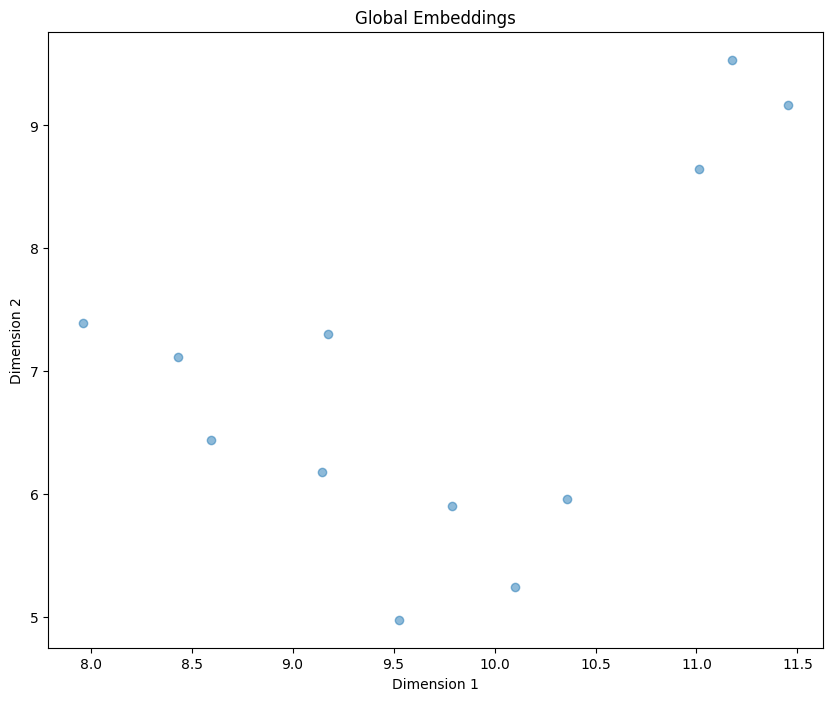

In [16]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
print(global_embeddings_reduced[0])
#
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

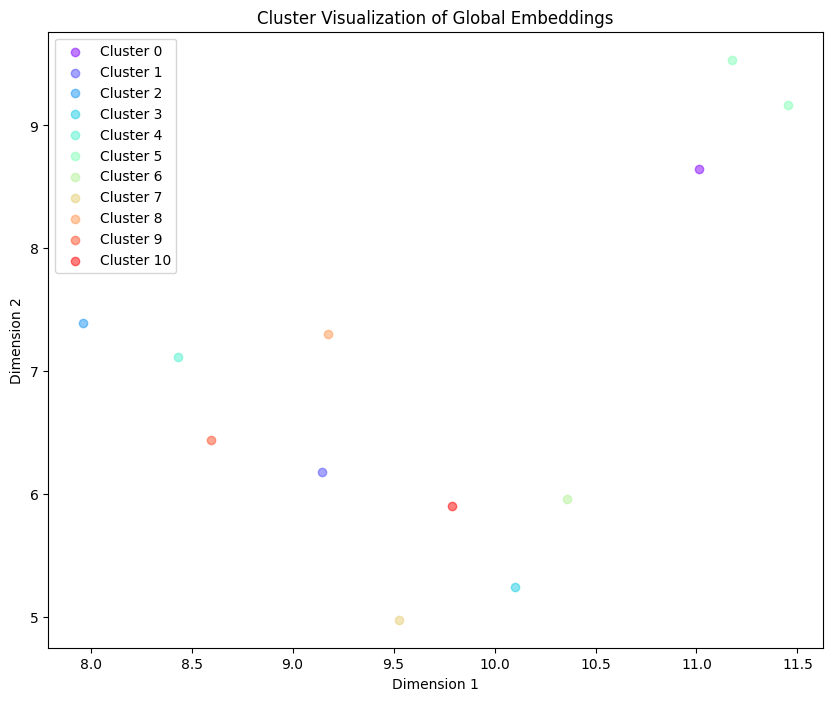

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters
#
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [18]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts_split,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text              Embedding  \
0  فوتبال ۳۶۰حساب کاربریپخش بازی لیورپول و منچستر...   [8.431068, 7.113435]   
1  نیم‌فصل نخست را در رده نخست به اتمام برساند و ...  [8.596694, 6.4414363]   
2  سیتی از حال ناخوش چکش‌ها9 ساعت پیشچلسی میهمان ...   [9.174404, 7.302095]   

   Cluster  
0        4  
1        9  
2        8  


In [19]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts
#
clustered_texts = format_cluster_texts(df)
#
clustered_texts

{4: 'فوتبال ۳۶۰حساب کاربریپخش بازی لیورپول و منچستریونایتد با گزارش عادل فردوسی\u200cپور یک\u200cشنبه, ساعت 20:00لایو ۳۶۰ با عادل فردوسی\u200cپور؛ ویژه بازی استقلال و سپاهان با حضور مهدی رحمتیتشریح اهداف نقل\u200cوانتقالاتی سپاهان؛ حاج\u200cصفی برمی\u200cگردد، وحدت، ارشیا و اسدی می\u200cروند؟سپاهان با کم\u200cترین ورودی و خروجی پا به نیمه دوم مسابقات خواهد گذاشت. آن\u200cها در بیشترین حالت با 3 ورودی و 3 خروجی کارشان را در پنجره زمستانی به پایان خواهند برد.رونمایی از جدول (1+4) در پایان نیم\u200cفصل؛ صدرنشینی مشترک پرسپولیس و تراکتور!مدعیان اصلی قهرمانی لیگ برتر در مصاف با یکدیگر عملکرد جالب\u200cتوجهی داشته\u200cاند و نمایش پرسپولیس و تراکتور نسبت به دیگر تیم\u200cها بهتر بوده است.مهم\u200cترین اتفاقات هفته پانزدهم؛ تراکتور صدرنشین نیم\u200cفصلنیم\u200cفصل اول با صدرنشینی تراکتور به پایان رسید.دومین صدرنشینی تراکتور در پایان نیم\u200cفصل اول؛ اسکوچیچ و تراکتور به طلسم\u200cشکنی فکر می\u200cکنند!تراکتور برای دومین\u200cبار موفق شد،',
 9: 'نیم\u200cفصل نخست را در رده نخست به اتمام برسان

In [21]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    # template = """Football 360 is a football site in Iran and follows all the news, results and transfers in the field of football in Iran and the world.

    # In the following section, I will give you a part of the data of this site and summarize it.

    # Details:
    # {context}
    # """

    template = """فوتبال 360 یک سایت فوتبالی در ایران است و تمامی اخبار و نتایج و نقل و انتقالات در حوزه فوتبال ایران و جهان رو دنبال میکند.

    در قسمت زیر یک بخشی از داده این سایت رو دراختیارت میزارم و اون روخلاصه کن.

    جزئیات:
    {context}"""
    
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [22]:
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 1 clusters--
Sending prompt to llama3.2: Human: فوتبال 360 یک سایت فوتبالی در ایران است و تمامی اخبار و نتایج و نقل و انتقالات در حوزه فوتبال ایران و جهان رو دنبال میکند.

    در قسمت زیر یک بخشی از داده این سایت رو دراختیارت میزارم و اون روخلاصه کن.

    جزئیات:
    فوتبال ۳۶۰حساب کاربریپخش بازی لیورپول و منچستریونایتد با گزارش عادل فردوسی‌پور یک‌شنبه, ساعت 20:00لایو ۳۶۰ با عادل فردوسی‌پور؛ ویژه بازی استقلال و سپاهان با حضور مهدی رحمتیتشریح اهداف نقل‌وانتقالاتی سپاهان؛ حاج‌صفی برمی‌گردد، وحدت، ارشیا و اسدی می‌روند؟سپاهان با کم‌ترین ورودی و خروجی پا به نیمه دوم مسابقات خواهد گذاشت. آن‌ها در بیشترین حالت با 3 ورودی و 3 خروجی کارشان را در پنجره زمستانی به پایان خواهند برد.رونمایی از جدول (1+4) در پایان نیم‌فصل؛ صدرنشینی مشترک پرسپولیس و تراکتور!مدعیان اصلی قهرمانی لیگ برتر در مصاف با یکدیگر عملکرد جالب‌توجهی داشته‌اند و نمایش پرسپولیس و تراکتور نسبت به دیگر تیم‌ها بهتر بوده است.مهم‌ترین اتفاقات هفته پانزدهم؛ تراکتور صدرنشین نیم‌فصلنیم‌فصل اول با صدرنشینی تراکتور به پایان رسید

In [23]:
# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)
#Final Summaries extracted
print(len(all_texts))

2


In [24]:
# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [25]:
from langchain.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

c:\Users\Iranian\Desktop\New folder (2)\.venv\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [27]:
from langchain.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.prompts import PromptTemplate

# Define a ChatPromptTemplate
prompt = ChatPromptTemplate(
    input_variables=["context", "question"],
    metadata={
        "lc_hub_owner": "rlm",
        "lc_hub_repo": "rag-prompt",
        "lc_hub_commit_hash": "50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e"
    },
    messages=[
        HumanMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=["context", "question"],
                template=(
                    "You are an assistant for question-answering tasks. "
                    "Use the following pieces of retrieved context to answer the question. "
                    "If you don't know the answer, just say that you don't know. "
                    "Use three sentences maximum and keep the answer concise.\n"
                    "Question: {question}\n"
                    "Context: {context}\n"
                    "Answer:"
                )
            )
        )
    ]
)

# Print the prompt
print(prompt)


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question}\nContext: {context}\nAnswer:"), additional_kwargs={})]


In [28]:
print(prompt.messages[0].prompt.template)


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:


In [29]:
# Question
response =rag_chain.invoke("رتبه نخست نیم فصل اول لیگ فوتبال ایران چه تیمی است؟")
print(str(response))

Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


Sending prompt to llama3.2: Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: رتبه نخست نیم فصل اول لیگ فوتبال ایران چه تیمی است؟ 
Context: فوتبال ۳۶۰حساب کاربریپخش بازی لیورپول و منچستریونایتد با گزارش عادل فردوسی‌پور یک‌شنبه, ساعت 20:00لایو ۳۶۰ با عادل فردوسی‌پور؛ ویژه بازی استقلال و سپاهان با حضور مهدی رحمتیتشریح اهداف نقل‌وانتقالاتی سپاهان؛ حاج‌صفی برمی‌گردد، وحدت، ارشیا و اسدی می‌روند؟سپاهان با کم‌ترین ورودی و خروجی پا به نیمه دوم مسابقات خواهد گذاشت. آن‌ها در بیشترین حالت با 3 ورودی و 3 خروجی کارشان را در پنجره زمستانی به پایان خواهند برد.رونمایی از جدول (1+4) در پایان نیم‌فصل؛ صدرنشینی مشترک پرسپولیس و تراکتور!مدعیان اصلی قهرمانی لیگ برتر در مصاف با یکدیگر عملکرد جالب‌توجهی داشته‌اند و نمایش پرسپولیس و تراکتور نسبت به دیگر تیم‌ها بهتر بوده است.مهم‌ترین اتفاقات هفته پانزدهم؛ ترا